# Modeling Techniques

#### In this dataset we detail how we selected, tuned, and compared different models; this all led to using a Gradient Boosting Regressor to predict Airbnb prices, with ~80% accuracy.

In [294]:
import numpy as np
from scipy import sparse
import re
import matplotlib
import pandas as pd
import seaborn as sns
from sklearn import linear_model
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression as LogReg
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestRegressor
import sklearn.metrics as metrics
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.ensemble import GradientBoostingRegressor
import matplotlib.cm as cmx
import matplotlib.colors as colors
from sklearn.feature_selection import SelectFromModel
import datetime as dt
import math
from sklearn.linear_model import Lasso as Lasso_Reg
import numpy as np 
import sklearn.preprocessing as Preprocessing
from sklearn.preprocessing import StandardScaler as Standardize
%matplotlib inline
from sklearn.linear_model import LinearRegression as Lin_Reg
from sklearn.linear_model import Ridge as Ridge_Reg
from scipy.stats.mstats import winsorize
from sklearn.grid_search import GridSearchCV

### Data Collection

In [91]:
# open final datasets 
listings = pd.read_csv('airbnb_final.csv')
prices = pd.read_csv('log_price.csv', header = None)

In [92]:
listings = listings.drop('Unnamed: 0', 1)
prices = prices.iloc[:, 1]

### Binary Encoding

In [94]:
# drop columns that we intuitively know would not help predict prices
abridged = listings.drop(['id', 'scrape_id', 'last_scraped', 'name', 'picture_url', 'host_id', 'host_name', 'host_picture_url', 'street', 'market', 'price', 'weekly_price', 'monthly_price', 'calendar_updated', 'calendar_last_scraped', 'is_location_exact'], 1)

In [95]:
abridged.columns

Index([u'neighbourhood_cleansed', u'city', u'zipcode', u'latitude',
       u'longitude', u'property_type', u'room_type', u'accommodates',
       u'bathrooms', u'bedrooms', u'beds', u'bed_type', u'guests_included',
       u'extra_people', u'minimum_nights', u'maximum_nights',
       u'availability_30', u'availability_60', u'availability_90',
       u'availability_365', u'number_of_reviews', u'review_scores_rating',
       u'review_scores_accuracy', u'review_scores_cleanliness',
       u'review_scores_checkin', u'review_scores_communication',
       u'review_scores_location', u'review_scores_value',
       u'host_listing_count', u'host_since', u'first_review', u'last_review',
       u'sentiment', u'Christmas', u'New Years', u'New Years Eve',
       u'Independence Day', u'July 4th', u'attraction_count'],
      dtype='object')

In [97]:
encoded_data = pd.DataFrame({}) 

# Iterate over all attributes
for column in abridged.columns:
    # Check if column has type 'object'
    if abridged[column].dtype == np.dtype('object'):
        # use one-hot encoding for this column
        encoding = pd.get_dummies(abridged[column])
        # append expanded attribute to data frame
        encoded_data = pd.concat([encoded_data, encoding], axis=1)
    else:
        encoded_data = pd.concat([encoded_data, abridged[[column]]], axis=1)

encoded_data.head()

,Allerton,Alphabet City,Astoria,Bath Beach,Battery Park City,Bay Ridge,Baychester,Bayside,Bedford Park,Bedford-Stuyvesant,...,host_since,first_review,last_review,sentiment,Christmas,New Years,New Years Eve,Independence Day,July 4th,attraction_count
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.049161,-0.093997,0.048728,0.283516,0,0,0,0,0,1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.010274,0.029741,0.057405,0.437795,0,0,0,0,0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.349120,-0.503387,0.014021,0.308604,0,0,0,0,0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.275522,0.164449,0.042220,0.000000,0,0,1,1,0,1
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.286492,-0.378771,0.044390,0.122600,0,0,0,0,0,0


### Model Selection

In [274]:
# split into train and test data 
X_train, X_test, y_train, y_test = train_test_split(encoded_data, prices, test_size=0.3)

In deciding which models to use, we pulled from our literature review as well as course topics. Literature review promoted Bayesian Ridge Regression as well as Gradient Boosting Regressor for Airbnb pricing, while topics from class suggested that Linear Regression, Ridge Regression, Lasso, or Random Forest Regressor might be the best approaches.

In Milestone 4 (jupyter notebook submitted at the time of the assignment), our linear regression model had an accuracy of approximately 50%. Of course, after taking in feedback from professors and TFs, we revised our model multiple times, and we see below that all of our models, even our originally "baseline" model of linear regression, beat the 50% benchmark after our revisions. Some of the noteworthy revisions that we believe helped us beat our baseline model include: revising our dataset to remove columns using feature selection techniques, taking the log of prices to make them into a more normal distribution, adding certain features like sentiment score, and binary encoding rather than label encoding our data.  

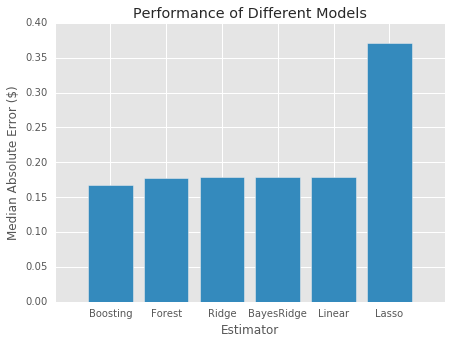

In [275]:
rs = 1

# the 6 models that we will compare 
ests = [ Lin_Reg(), Ridge_Reg(),
        Lasso_Reg(), linear_model.BayesianRidge(), RandomForestRegressor(), GradientBoostingRegressor()]
ests_labels = np.array(['Linear', 'Ridge', 'Lasso', 'BayesRidge', 'Forest', 'Boosting'])
errvals = np.array([])

# look at the median absolute error for each model
for e in ests:
    e.fit(X_train, y_train)
    prediction = e.predict(X_test)
    this_err = metrics.median_absolute_error(y_test, prediction)
    errvals = np.append(errvals, this_err)

# arrange models in terms of lowest to highest median error score
pos = np.arange(errvals.shape[0])
srt = np.argsort(errvals)
plt.figure(figsize=(7,5))
plt.bar(pos, errvals[srt], align='center')
plt.style.use('ggplot')
plt.xticks(pos, ests_labels[srt])
plt.xlabel('Estimator')
plt.ylabel('Median Absolute Error ($)')
plt.title('Performance of Different Models')

Above, we see extremely interesting results when we calculate median error score for each model (on a log scale). Boosting has the lowest error, but Random Forest, Ridge, Bayesian Ridge, and Linear are all very comparable! Lasso performed the worse, however, and so we will rule that out of our following explorations. 

Below we will cross-validate and tune each model in order to determine what the "best" and least overfitting model is. 

#### Cross-Validation

In [168]:
def cv_optimize(clf, parameters, X, y, n_jobs=1, n_folds=5, score_func=None):
    if score_func:
        gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds, n_jobs=n_jobs, scoring=score_func)
    else:
        gs = GridSearchCV(clf, param_grid=parameters, n_jobs=n_jobs, cv=n_folds)
    gs.fit(X, y)

    best = gs.best_estimator_
    return best

##### Ridge Regression

In [174]:
# gridsearchcv for Ridge Regression
ridge =  Ridge_Reg()

ridge.fit(X_train, y_train)
print 'Before cross-validation, the ridge regression score is', ridge.score(X_test, y_test), '\n'

# parameters to tune
parameters = {"alpha": [.0001, .001, .01, .1, 1, 10, 100, 1000]}
ridge_new = cv_optimize(ridge, parameters, X_train, y_train, n_jobs=10, n_folds=5, score_func=None)

# print details of the new model
print 'Best Alpha:', ridge_new.alpha
best_ridge = Ridge_Reg(alpha = ridge_new.alpha)
best_ridge.fit(X_train, y_train)
print 'After cross-validation, the ridge regression score is', best_ridge.score(X_test, y_test)

Before cross-validation, the ridge regression score is 0.748186403106 

Best Alpha: 1
After cross-validation, the ridge regression score is 0.748186403106


Tuning has no notable difference on ridge regression

##### Bayes Ridge Regression

In [175]:
# gridsearchv for Bayes Ridge
bayes = linear_model.BayesianRidge()

bayes.fit(X_train, y_train)
print 'Before cross-validation, the Bayes ridge regression score is', bayes.score(X_test, y_test), '\n'

# parameters to tune
parameters = {"alpha_1": [1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3], 
             "lambda_1": [1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3]}
bayes_new = cv_optimize(bayes, parameters, X_train, y_train, n_jobs=10, n_folds=5, score_func=None)

# print details of the new model 
print 'Best Alpha_1:', bayes_new.alpha_1
print 'Best Alpha_2:', bayes_new.alpha_2
print 'Best Lambda_1:', bayes_new.lambda_1
print 'Best Lambda_2:', bayes_new.lambda_2

best_bayes = linear_model.BayesianRidge(alpha_1= bayes_new.alpha_1, alpha_2= bayes_new.alpha_2, lambda_1= bayes_new.lambda_1, lambda_2= bayes_new.lambda_2)
best_bayes.fit(X_train, y_train)
print 'After cross-validation, the bayes ridge regression score is', best_bayes.score(X_test, y_test)

Before cross-validation, the Bayes ridge regression score is 0.742211997496 

Best Alpha_1: 0.001
Best Alpha_2: 1e-06
Best Lambda_1: 1e-08
Best Lambda_2: 1e-06
After cross-validation, the bayes ridge regression score is 0.742212000971


Tuning has no notable difference on bayesian ridge regression

##### Random Forest Regressor

In [176]:
# gridsearchcv for Random Forest
forest =  RandomForestRegressor()

forest.fit(X_train, y_train)
print 'Before cross-validation, the Random Forest Regressor score is', forest.score(X_test, y_test), '\n'

parameters = {"max_depth": [3, 5, 8, 10, 12], 'max_features': [0.2, 0.4, 0.6, 0.8], 'min_samples_leaf': [2, 5, 8, 12]}
forest_new = cv_optimize(forest, parameters, X_train, y_train, n_jobs=10, n_folds=5, score_func=None)

print 'Max Features:', forest_new.max_features
print 'Max Depth:', forest_new.max_depth
print 'Min Samples per Leaf:', forest_new.min_samples_leaf

best_forest = RandomForestRegressor(max_depth = forest_new.max_depth, max_features = forest_new.max_features, min_samples_leaf = forest_new.min_samples_leaf)
best_forest.fit(X_train, y_train)
print 'After cross-validation, the random forest score is', best_forest.score(X_test, y_test)

Before cross-validation, the Random Forest Regressor score is 0.746834388371 

Max Features: 0.8
Max Depth: 12
Min Samples per Leaf: 5
After cross-validation, the random forest score is 0.750472355445


Tuning increased random forest score by 1% 

##### Gradient Boosting Regressor

In [178]:
# gridsearchcv for Gradient Boosting
booster =  GradientBoostingRegressor()

booster.fit(X_train, y_train)
print 'Before cross-validation, the Gradient Boosting Regressor score is', booster.score(X_test, y_test), '\n'

parameters = {"max_depth": [1, 3, 5, 8], 'learning_rate': [0.1, 0.15, 0.2], 'max_features': [0.2, 0.4, 0.6, 0.8]}
booster_new = cv_optimize(booster, parameters, X_train, y_train, n_jobs=10, n_folds=5, score_func=None)

print 'Max Features:', booster_new.max_features
print 'Max Depth:', booster_new.max_depth
print 'Learning Rate:', booster_new.learning_rate

best_booster = GradientBoostingRegressor(max_depth = booster_new.max_depth, max_features = booster_new.max_features, min_samples_leaf = booster_new.min_samples_leaf)
best_booster.fit(X_train, y_train)
print 'After cross-validation, the Gradient Boosting Regressor score is', best_booster.score(X_test, y_test)

Before cross-validation, the Gradient Boosting Regressor score is 0.773388900856 

Max Features: 0.6
Max Depth: 5
Learning Rate: 0.15
After cross-validation, the Gradient Boosting Regressor score is 0.791936252836


Tuning increased Gradient Boosting score by 2%

After tuning, we still see that gradient boosting regressor performed the best. We were also pleased with how it tuned its features; particularly, a max depth of 5 shows that Gradient Boosting Regressor is not overfitting (larger depth implies more overfitting, and so a max depth of 5 demonstrates little overfitting). 

#### Comparisons to the Baseline

We wrote a function that compared each prediction of a model to that of the baseline, Linear Regression. We wanted to make sure that these models weren't simply getting higher scores than linear regression because of a few points (while perhaps the remainder of points larger errors than each linear regression error). 

This function thus analyzes the number of predictions that beat the baseline's predictions. The results are both surprising and informative!

In [226]:
def closer_score(model):
    
    # perform multivariate regression
    clf = Lin_Reg()
    clf.fit(X_train, y_train)
    
    #model prediction
    adv = model
    adv.fit(X_train, y_train)
    
    #compare models
    lin_predict = clf.predict(X_test)
    adv_predict = adv.predict(X_test)
    y_test1 = pd.DataFrame(y_test)

    y_test1.columns = ['price']
    y_test1['lin_predict'] = lin_predict
    y_test1['adv_predict'] = adv_predict
    
    y_test1['score'] = 0.0
    mask = y_test1.loc[abs(y_test1['price'] - y_test1['adv_predict']) < abs(y_test1['price'] - y_test1['lin_predict'])].index
    y_test1.loc[mask,'score'] = 1.0
    score = np.mean(y_test1.score)
    return score

In [277]:
print "We compared how each prediction in each model compared to the baseline model's predictions \n"
print 'Ridge Regression is better ' + str(round(closer_score(best_ridge), 3)) + '% of the time'
print 'Bayes Ridge is better ' + str(round(closer_score(best_bayes), 3)) + '% of the time'
print 'Random Forest is better ' + str(round(closer_score(best_forest), 3)) + '% of the time'
print 'Gradient Boosting is better ' + str(round(closer_score(best_booster), 3)) + '% of the time'


We compared how each prediction in each model compared to the baseline model's predictions 

Ridge Regression is better 0.494% of the time
Bayes Ridge is better 0.494% of the time
Random Forest is better 0.505% of the time
Gradient Boosting is better 0.548% of the time


Interestingly, Ridge, Bayes, and Random Forest all essentially beat linear regression only half of the time, and thus we ruled those models out. Only Gradient Boosting Regressor shows a more significant improvement over linear regression. We hypothesized that linear regression performed so well because after normalizing log prices, more of the variables demonstrated a more linear relationship with price than we could see before. This intuitively makes sense; as review scores go up for instance, price is likely to increase with that. Gradient Boosting Regressor, meanwhile, performed best because it could discount certain features, it was able to tune more parameters, and it is able to learn from mistakes of previous regression trees. Thus our literature proved to be extremely useful -- Gradient Boosting Regressor, as read in the literature, did indeed perform the best! 

Below, we finalize our model for Gradient Boosting. 

### Gradient Boosting: Feature Selection

In [238]:
# dropped 'city' and 'zipcode' because added a lot of features to our dataset after binary encoding 
# moreover, we believed neighbourhoods had very similar information to city and zipcodes and so all 3 weren't necessary
revised_data = encoded_data.drop(['city', 'zipcode'], 1)

# use SelectFromModel package (after exploring Kmeans, feature clustering, etc) to feature select
boosting_model = best_booster.fit(revised_data, prices)
boosting_model_final = SelectFromModel(boosting_model, threshold = 'mean', prefit=True)
X_new1 = boosting_model_final.transform(revised_data)

In [240]:
# score after feature selection
X_train, X_test, y_train, y_test = train_test_split(X_new1, prices, test_size=0.3)

best_booster.fit(X_train, y_train)
best_booster.score(X_test, y_test)

0.80176954194139016

Feature selection did indeed improve our score; though negligibly, we were very pleased by this result because with less features, there is less potential for overfitting and less computational complexity.

#### Final Tuning of Model

We fine-tuned our model one last time because we hypothesized that with reduced features, the max number of features parameter might change for gradient boosting regressor.

In [241]:
# cross_validation using GridSearchCV
parameters = {"max_depth": [1, 3, 5, 8], 'learning_rate': [0.1, 0.15, 0.2], 'max_features': [0.2, 0.4, 0.6, 0.8]}
booster_new = cv_optimize(best_booster, parameters, X_train, y_train, n_jobs=10, n_folds=5, score_func=None)

print 'Max Features:', booster_new.max_features
print 'Max Depth:', booster_new.max_depth
print 'Learning Rate:', booster_new.learning_rate

best_booster1 = GradientBoostingRegressor(max_depth = booster_new.max_depth, max_features = booster_new.max_features, min_samples_leaf = booster_new.min_samples_leaf)
best_booster1.fit(X_train, y_train)
print 'After cross-validation, the Gradient Boosting Regressor score is', best_booster1.score(X_test, y_test)

Max Features: 0.8
Max Depth: 5
Learning Rate: 0.15
After cross-validation, the Gradient Boosting Regressor score is 0.804166633756


Our hypothesis was indeed correct! While max depth and learning rate remained the same as our previously tuned Gradient Boosting model (prior to feature selection), max features increased; this makes sense, as the number of features was drastically reduced (from over 300 to 46!).  

### Distribution of Error

With our final model, we desired to see how its distribution of errors compared to our other models. We used a boxplot to demonstrate these results. On our website, we have zoomed in for purposes of visualization, but when we zoom into the pictures (as shown below), we see that there is a large number of outliers above the primary distribution, but Gradient Boosting Regressor has the least number of outliers, which have the smallest magnitude. 

In [268]:
# split on the new dataset (with reduced features)
X_train, X_test, y_train, y_test = train_test_split(X_new1, prices, test_size = 0.3)

# all models after tuning
model1 = Lin_Reg()
model2 = best_forest
model3 = best_booster1
model4 = best_ridge
model5 = best_bayes
error = pd.DataFrame(columns = ['LinReg', 'Random Forest', 'Boosting', 'Bayes Ridge', 'Ridge'])
models = [model1, model2, model3, model4, model5]

# exponentiate y_test (since currently log values)
y_test_exp = []
for i in range(len(y_test)):
    y_test_exp.append(math.exp(y_test.iloc[i]))

# calculate absolute value of error for each point 
for i in range(len(models)):
    model = models[i]
    model.fit(X_train, y_train)
    predicted = model.predict(X_test)
    differences = []
    for j in range(len(predicted)):
        predicted_exp = math.exp(predicted[j])
        differences.append(abs(y_test_exp[j] - predicted_exp))
    # add the column of differences to error dataset
    error[error.columns[i]] = differences

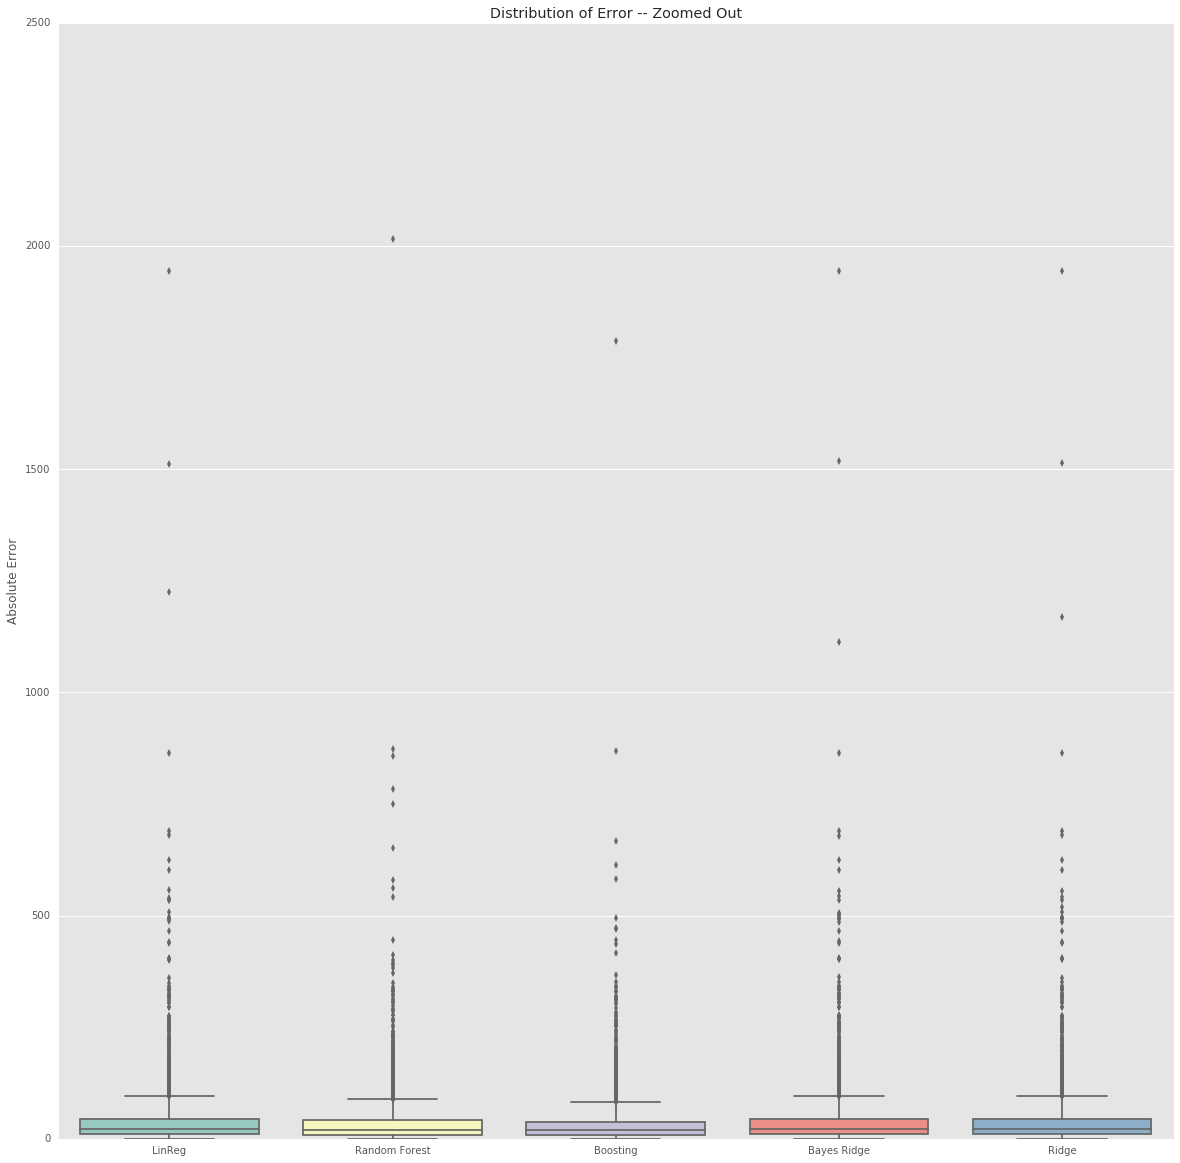

In [293]:
# use seaborn to make a boxplot of the errors
fig, (ax1) = plt.subplots(1, 1, figsize = (20, 20))

ax1 = sns.boxplot(data=error, palette= 'Set3')
ax1.set_ylabel('Absolute Error')
ax1.set_title('Distribution of Error -- Zoomed Out')
ax1.set_ylim(0, 2500)

plt.show()

We attempt to feature engineer and explore where outliers might be occurring in a separate Jupyter notebook; for instance, after feature engineering, we learned that we needed to standardize certain features and winsorize others. 

### Feature Ranking

In order to check our intuition about which features mattered most, we plot how Gradient Boosting Regressor ranks the features in the dataset. 

In [272]:
final_features1 = pd.DataFrame()

# X_new1 is a matrix, and so converting it back to dataframe with proper feature labels
for i in range(X_new1.shape[1]):
    for j in range(encoded_data.shape[1]):
        column = encoded_data.iloc[:, j]
        if np.array_equal(X_new1[:, i], column) == True:
            final_features1[encoded_data.columns[j]] = encoded_data.iloc[:, j]

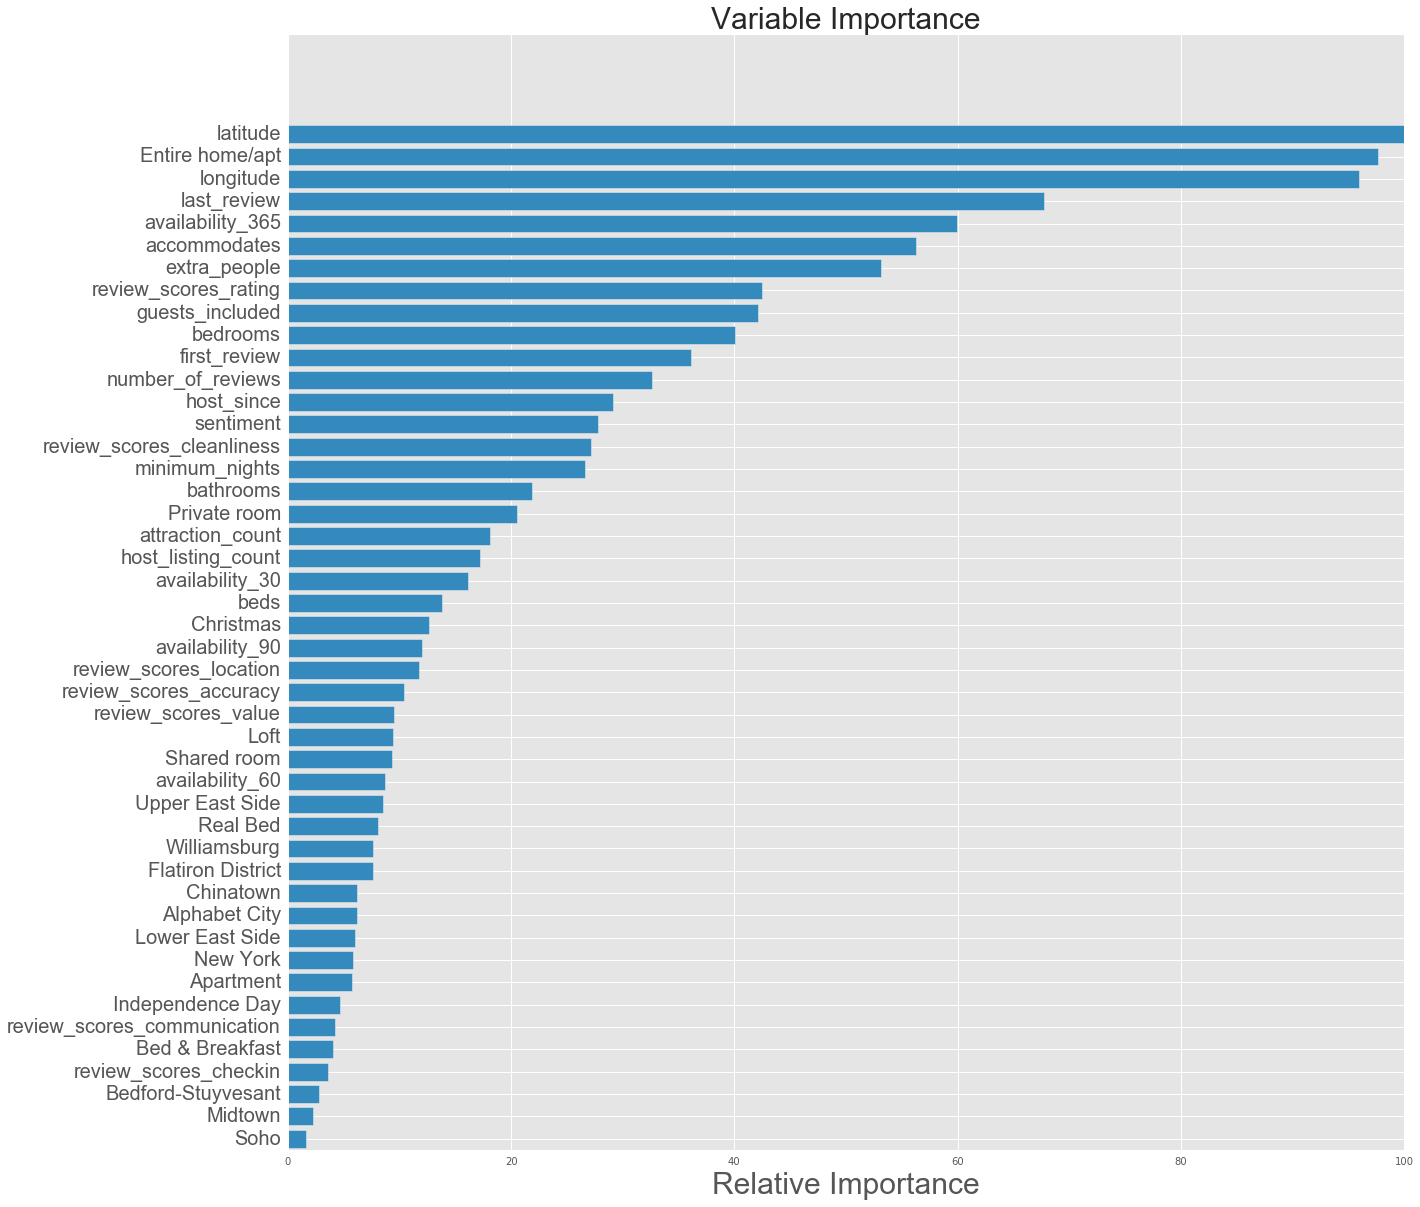

In [273]:
# graph to rank feature importance 
feature_importance = best_booster1.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
pvals = feature_importance[sorted_idx]
pcols = final_features1.columns[sorted_idx]
plt.style.use('ggplot')

# labels for graph 
plt.figure(figsize=(20,20))
plt.barh(pos, pvals, align='center')
plt.yticks(pos, pcols, fontsize = 20)

plt.xlabel('Relative Importance', fontsize = 30)
plt.title('Variable Importance', fontsize = 30)

Our hypotheses were not far off base! Location matters most in New York, which of course makes most sense; people will pay more to stay in Central Park than out in Brooklyn. Some of the features we added, like attraction_count and sentiment analysis, performed quite well as well! This also makes sense -- one's location to top sites and one's past reviews will all make a difference in how people view the place and how the apartment is thus priced. 